## MLFlow with Scikit Learn

## 1.1 - (Installing and) Loading Basic Packages

In [0]:
#!pip install -U -q scikit-learn 
#!pip install -U -q imbalanced-learn 
#!pip install -U -q xgboost 
#!pip install -U -q lightgbm 
!pip install -U -q rgf_python 
!pip install -U -q catboost
#!pip install -U -q forestci
!pip install -U -q tpot 
#!pip install -U -q pycaret
#!pip install -U -q tensorflow tensorboard 
#!pip install -U -q torch torchvision 
#!pip install -U -q delayed
#!pip install -U -q joblib 
#!pip install -U -q joblibspark

In [0]:
import os
import sys
import time
import pickle
import itertools
import warnings
import string
import re

import numpy as np
import pylab
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
username = "renato"
logpath = os.path.join("/", "tmp", username)    #If we were writing to the root folder and not to the DBFS
if not os.path.exists(logpath):
    os.mkdir(logpath)

## 1.3 - (Not) Disabling [MLFlow autologging](https://docs.databricks.com/mlflow/databricks-autologging.html)

In [0]:
import mlflow
#mlflow.autolog(disable=True)

# 2 - Loading Dataset

In [0]:
datapath = "../../Module_B/Day2/data/Titanic"

In [0]:
df_train = pd.read_csv(os.path.join(datapath,'kaggle_titanic_train.csv'))
# df_test = pd.read_csv(os.path.join(datapath,'kaggle_titanic_test.csv')) # No labels, not using

# 3 - Data Transformations
 + Creating Train and Test subsets
 + Encoding Categorical Fields (Sex, Embarked, Name, Ticket, Cabin) 
 + Decide how to fill the Missing Values (Embarked, Cabin, Age)  
 + Standardizing Numerical Fields (Age, Pclass, SibSp, Parch, Fare) + Encoded Categorical Fields
 + Encoding Target variable (Survived))¶

In [0]:
# https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn import model_selection

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder

# https://scikit-learn.org/stable/modules/impute.html
from sklearn.impute import SimpleImputer

# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html
from sklearn.preprocessing import LabelBinarizer

## 3.1 - Creating train & test subsets:

In [0]:
df_train.drop(["PassengerId"], axis=1, inplace=True)
y = df_train.pop("Survived")
y

Out[378]: 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train, y, test_size=0.2, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


## 3.2 - Transforming Sex/Gender (stateful/binary)

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train['Sex'].values.reshape(-1, 1))

Out[380]: OneHotEncoder(handle_unknown='ignore')

In [0]:
enc.categories_[0]

Out[381]: array(['female', 'male'], dtype=object)

In [0]:
gender_train = pd.DataFrame(enc.transform(X_train['Sex'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0], dtype=np.int8)
gender_test = pd.DataFrame(enc.transform(X_test['Sex'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0], dtype=np.int8)

In [0]:
X_train.drop(['Sex'], axis=1, inplace=True)
X_train = pd.concat([X_train, gender_train], axis=1)
X_test.drop(['Sex'], axis=1, inplace=True)
X_test = pd.concat([X_test, gender_test], axis=1)

## 3.3 - Transforming Embarked (stateful)  
 We can decide to substitute the missing values using a missing value imputation technique, or simply encoding the missing values as an additional category using OHE

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train['Embarked'].values.reshape(-1, 1))

Out[384]: OneHotEncoder(handle_unknown='ignore')

In [0]:
embarked_train = pd.DataFrame(enc.transform(X_train['Embarked'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0],dtype=np.int8)
embarked_train.rename({np.nan: "U"}, axis='columns', inplace=True)   #Rename the column with name "nan" to avoid further problems
embarked_test = pd.DataFrame(enc.transform(X_test['Embarked'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0],dtype=np.int8)
embarked_test.rename({np.nan: "U"}, axis='columns', inplace=True)

In [0]:
embarked_train.columns

Out[386]: Index(['C', 'Q', 'S', 'U'], dtype='object')

In [0]:
X_train.drop(['Embarked'], axis=1, inplace=True)
X_train = pd.concat([X_train, embarked_train], axis=1)
X_test.drop(['Embarked'], axis=1, inplace=True)
X_test = pd.concat([X_test, embarked_test], axis=1)

## 3.4 - Transforming Name (stateful)  
Name is a textual field. We can be very creative when deciding to create features, vectorizing every word, etc.  
In this notebook, we will just extract the titles and surnames and create features out of it.

In [0]:
# Create function that take name and separates it into title, family name and deletes all puntuation from name column:
def name_sep(data):
    families=[]
    titles = []
    new_name = []
    #for each row in dataset:
    for i in range(len(data)):
        name = data.iloc[i]
        # extract name inside brackets into name_bracket:
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]
        
        #remove punctuations accept brackets:
        for c in string.punctuation:
            name = name.replace(c,"").strip()
            family = family.replace(c,"").strip()
            title = title.replace(c,"").strip()
            
        families.append(family)
        titles.append(title)
        new_name.append(name)
            
    return families, titles, new_name 

In [0]:
dict_train_name = dict(zip(['surname', 'title', 'newname'], name_sep(X_train["Name"])))
X_train_name = pd.DataFrame(dict_train_name)
dict_test_name = dict(zip(['surname', 'title', 'newname'], name_sep(X_test["Name"])))
X_test_name = pd.DataFrame(dict_test_name)

Let's reduce the feature space converting some equivalent titles:

In [0]:
X_train_name['title'] = X_train_name['title'].replace(['Ms', 'Mlle'],'Miss')
X_train_name['title'] = X_train_name['title'].replace(['Mme'],'Mrs')
X_train_name['title'] = X_train_name['title'].replace(['Dr','Rev','the','Jonkheer','Lady','Sir', 'Don'],'Nobles')
X_train_name['title'] = X_train_name['title'].replace(['Major','Col', 'Capt'],'Navy')

X_test_name['title'] = X_test_name['title'].replace(['Ms', 'Mlle'],'Miss')
X_test_name['title'] = X_test_name['title'].replace(['Mme'],'Mrs')
X_test_name['title'] = X_test_name['title'].replace(['Dr','Rev','the','Jonkheer','Lady','Sir', 'Don'],'Nobles')
X_test_name['title'] = X_test_name['title'].replace(['Major','Col', 'Capt'],'Navy')

### 3.4.1 - Encoding Title

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_name['title'].values.reshape(-1, 1))

Out[391]: OneHotEncoder(handle_unknown='ignore')

In [0]:
title_train = pd.DataFrame(enc.transform(X_train_name['title'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0],dtype=np.int8)
title_test = pd.DataFrame(enc.transform(X_test_name['title'].values.reshape(-1, 1)).toarray(), columns=enc.categories_[0],dtype=np.int8)

In [0]:
X_train.drop(['Name'], axis=1, inplace=True)
X_train = pd.concat([X_train, title_train], axis=1)
X_test.drop(['Name'], axis=1, inplace=True)
X_test = pd.concat([X_test, title_test], axis=1)

### 3.4.2 - Encoding Surname

In [0]:
!pip install -U -q category_encoders

In [0]:
import category_encoders as ce

In [0]:
enc = ce.count.CountEncoder(verbose=0)
enc.fit(X_train_name.surname)

Out[396]: CountEncoder(cols=['surname'], combine_min_nan_groups=True)

In [0]:
surnames_train = pd.DataFrame(enc.transform(X_train_name.surname), columns=enc.get_feature_names())
X_train = pd.concat([X_train, surnames_train], axis=1)

surnames_test = pd.DataFrame(enc.transform(X_test_name.surname), columns=enc.get_feature_names())
X_test = pd.concat([X_test, surnames_test], axis=1)

## 3.5 - Transforming Ticket (stateless)

We can indeed data mine out some interesting relationship from Ticket number. But I think it is best to drop it.  
We could find some relationship between Pclass and Ticket number, and although one could see that there might be some relationship between them, it is not very strong  
We decided to drop this variable as well.

In [0]:
X_train.drop(['Ticket'], axis=1, inplace=True)
X_test.drop(['Ticket'], axis=1, inplace=True)

## 3.6 - Transforming Cabin (stateful)

In [0]:
X_train['Cabin'].value_counts()

Out[399]: C23 C25 C27    3
G6             3
C22 C26        3
E101           3
D              3
              ..
D17            1
D50            1
A14            1
A36            1
E49            1
Name: Cabin, Length: 127, dtype: int64

In [0]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [X_train, X_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [0]:
X_train.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)

## 3.7 - Transforming Age (stateful)  
We will use the iterative inputer that chooses to fill the missing values using a model with the other features

In [0]:
imp_mean = IterativeImputer(random_state=0)

In [0]:
imp_mean.fit(X_train)

2022/12/11 13:46:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb3f43c18277494cba94126398b43bf2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/11 13:46:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0bb61d5ee78144bda4548ef519d38542', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/11 13:46:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '41b6093e89e943dbb46b71f620a324b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/11 13:46:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '967ce87b90384be49325a666562ae579', which will track hyperparameters, performance metrics, model artifacts, and lineage i

In [0]:
X_train = pd.DataFrame(imp_mean.transform(X_train.values), columns=X_train.columns)
X_test = pd.DataFrame(imp_mean.transform(X_test.values), columns=X_test.columns)

## 3.8 - Dealing with numeric fields values
+ Check there are no more missing values   
+ Check all features are numeric
+ Standardizing features

In [0]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


In [0]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()

for column in X_train.columns:
    scaler.fit(X_train[column].values.reshape(-1, 1))
    X_train[column] = scaler.transform(X_train[column].values.reshape(-1, 1))
    X_test[column] = scaler.transform(X_test[column].values.reshape(-1, 1))

## 3.9 - Balancing the classes  

As the unbalance is not that big, you can experiment running the algorithms without balancing as well

In [0]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))

439
273


### 3.9.1 - Oversampling the minority class

In [0]:
# http://contrib.scikit-learn.org/imbalanced-learn/  
from imblearn.over_sampling import SMOTE

In [0]:
smote = SMOTE(random_state=0)

X_train, y_train = smote.fit_resample(X_train, y_train)

2022/12/11 13:48:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a1d034e7773243568bbce7d1ace07a8e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/11 13:48:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/12/11 13:48:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature


In [0]:
print(X_train.shape)
print(y_train.shape)
print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))
print(X_test.shape)
print(y_test.shape)
print(len(y_test[y_test == 0]))
print(len(y_test[y_test == 1]))

(878, 19)
(878,)
439
439
(179, 19)
(179,)
110
69


# 4 - Metrics and Evaluation Functions

## 4.1 - Importing Metrics

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV   


# If we are using a spark environment we can paralelize grid search
from joblibspark import register_spark
from sklearn.utils import parallel_backend
register_spark()

## 4.2 - Creating Cross validation folds   
This will make more precise the evaluation of the classifiers when doing grid search.  
Bear in mind that this also affects the sample used for training, making the performance slighty worse than when using the whole dataset
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [0]:
#cv = model_selection.StratifiedKFold(n_splits=10)
cv = model_selection.KFold(n_splits=10)

## 4.3 - Creating functions to evaluate the models

These functions can be put aside in a python file and imported, to make the code less cluttered

In [0]:
def mean_scores_cv(clf, cv, X, y):
    print("Using f1 score")
    scores = model_selection.cross_val_score(clf, X, y, 
                                             scoring="f1", 
                                             cv=cv, 
                                             n_jobs=1,
                                             verbose=0,
                                             fit_params=None,
                                             pre_dispatch='2*n_jobs')
    return scores.mean()



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
    
def clf_eval(clf, X, y_true, classes=['Perished', 'Survived']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

# 5 - Running Models

## 5.1 - Linear Classifiers

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

### 5.1.1 - [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  

Logistic regression is a classification algorithm based on the function which is used at the core of the method, logistic function or sigmoid function. It’s an S-shaped curve that is used to predict a binary outcome (1/0, Yes/No, True/False) given a set of independent variables.

+ It can also be thought of as a special case of linear regression when the outcome variable is categorical, where we are using the log of odds as a dependent variable.
+ It predicts the probability of occurrence of an event by fitting data to a logit function.

\\(f(x) = \frac{L}{1 + e^{-k(x-x_0)}}\\) 

Logistic regression, or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical. In the binary case, a dependent variable (the output) can take only two values, "0" and "1", which represent outcomes such as pass/fail, win/lose, alive/dead or healthy/sick. Cases where the dependent variable has more than two outcome categories may be analysed in multinomial logistic regression, or, if the multiple categories are ordered, in ordinal logistic regression.


![Logistic](https://www.saedsayad.com/images/LogReg_1.png)

In [0]:
from sklearn.linear_model import LogisticRegression

Using f1 score
This is the cross validated score of the model: 0.778212301394676

Classification Report
              precision    recall  f1-score   support

    Perished       0.88      0.84      0.86       110
    Survived       0.76      0.81      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8239789196310936
Accuracy Score: 0.8268156424581006
Average Precision Score: 0.6868050951121148
f1 Score: 0.7832167832167832
Confusion matrix, without normalization
[[92 18]
 [13 56]]


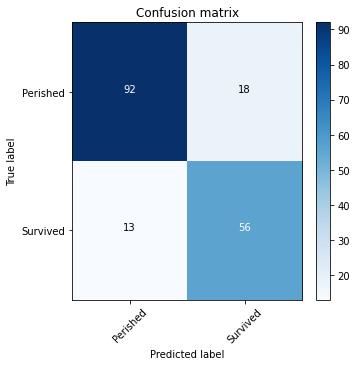

In [0]:
with mlflow.start_run(run_name="LR-1") as run:
    clf_lr = LogisticRegression(penalty='l2',
                                dual=False, 
                                tol=0.001, 
                                C=0.10, 
                                fit_intercept=True, 
                                intercept_scaling=1, 
                                class_weight=None, 
                                random_state=0, 
                                solver='saga', 
                                max_iter=100, 
                                multi_class='ovr', 
                                verbose=0, 
                                warm_start=False, 
                                n_jobs=-1).fit(X_train, y_train)

    cv_lr = mean_scores_cv(clf_lr, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_lr}\n")
    
    roc_lr = clf_eval(clf_lr, X_test, y_test)
    mlflow.log_metric("roc", roc_lr)

### 5.1.1.2 - Logistic Regression with Grid Search

For each model, we can also run with hyperparameter search for finding the best parameters

2022/12/11 13:49:07 INFO mlflow.sklearn.utils: Logging the 5 best runs, 235 runs will be omitted.
0.806308777429467
0.1111111111111111
10
1e-05
Classification Report
              precision    recall  f1-score   support

    Perished       0.88      0.83      0.85       110
    Survived       0.75      0.83      0.79        69

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8266798418972333
Accuracy Score: 0.8268156424581006
Average Precision Score: 0.6866043235365558
f1 Score: 0.786206896551724
Confusion matrix, without normalization
[[91 19]
 [12 57]]


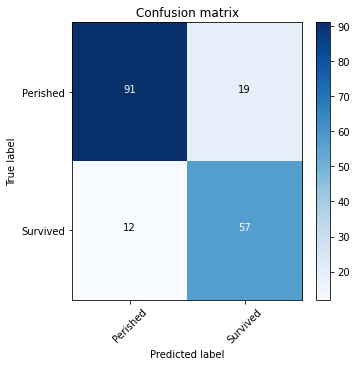

In [0]:
with mlflow.start_run(run_name="LR-GS") as run:
    estimator = LogisticRegression(dual=False, 
                                   penalty='l2',
                                   fit_intercept=True, 
                                   intercept_scaling=1, 
                                   class_weight=None, 
                                   random_state=0, 
                                   solver='saga', 
                                   multi_class='ovr', 
                                   verbose=0, 
                                   warm_start=False, 
                                  n_jobs=1)

    Cs = np.linspace(0,1,10)
    max_iter = [10, 50, 100, 200]
    tol = [1e-5, 1e-4, 1e-3]
    fi = [True, False]
    param_grid=dict(C=Cs, max_iter=max_iter, tol=tol, fit_intercept=fi)


    clf_lr2 = model_selection.GridSearchCV(param_grid=param_grid,                       ## Grid Search (more exhaustive)
    #clf_lr2 = model_selection.RandomizedSearchCV(param_distributions=param_grid,       ## Randomized (faster)
                                                  estimator=estimator,
                                                  cv=cv,                                       ## using cross validation
                                                  n_jobs=1)
    clf_lr2.fit(X_train, y_train)

    print(clf_lr2.best_score_)
    print(clf_lr2.best_estimator_.C)
    print(clf_lr2.best_estimator_.max_iter)
    print(clf_lr2.best_estimator_.tol)
    
    roc_lr = clf_eval(clf_lr2, X_test, y_test)
    mlflow.log_metric("roc", roc_lr)

### 5.1.2 - [Ridge Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)  

Ridge Classifiers addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients.  
The ridge coefficients minimize a penalized residual sum of squares  
https://stats.stackexchange.com/questions/558900/why-ridgeclassifier-can-be-significantly-faster-than-logisticregression-with-a-h

In [0]:
from sklearn.linear_model import RidgeClassifier

Using f1 score
This is the cross validated score of the model: 0.7708190006000166

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.85      0.86       110
    Survived       0.76      0.80      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8212779973649538
Accuracy Score: 0.8268156424581006
Average Precision Score: 0.6871092309214728
f1 Score: 0.7801418439716311
Confusion matrix, without normalization
[[93 17]
 [14 55]]


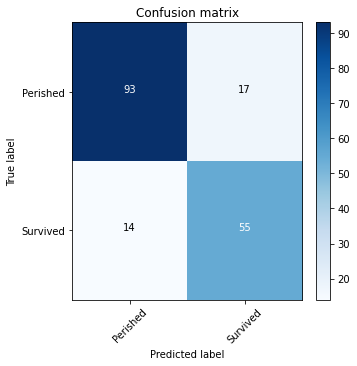

In [0]:
with mlflow.start_run(run_name="Ridge") as run:
    clf_rdg = RidgeClassifier(alpha=1.0, 
                              fit_intercept=True, 
                              normalize=False, 
                              copy_X=True, 
                              max_iter=None, 
                              tol=0.001, 
                              class_weight=None, 
                              solver='auto', 
                              random_state=0).fit(X_train, y_train)

    cv_rdg = mean_scores_cv(clf_rdg, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_rdg}\n")

    roc_rdg = clf_eval(clf_rdg, X_test, y_test)
    mlflow.log_metric("roc", roc_rdg)

### 5.1.3 - [Perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)

Perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

In [0]:
from sklearn.linear_model import Perceptron

Using f1 score
This is the cross validated score of the model: 0.6971687201145927

Classification Report
              precision    recall  f1-score   support

    Perished       0.91      0.78      0.84       110
    Survived       0.71      0.87      0.78        69

    accuracy                           0.82       179
   macro avg       0.81      0.83      0.81       179
weighted avg       0.83      0.82      0.82       179

ROC Score: 0.8256916996047431
Accuracy Score: 0.8156424581005587
Average Precision Score: 0.6713973420312987
f1 Score: 0.7843137254901961
Confusion matrix, without normalization
[[86 24]
 [ 9 60]]


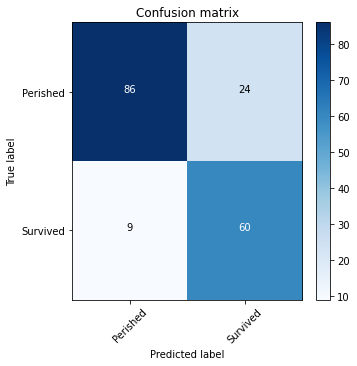

In [0]:
with mlflow.start_run(run_name="Perceptron") as run:
    clf_pcp = Perceptron(penalty=None,
                         alpha=0.001,
                         fit_intercept=True,
                         max_iter=230,
                         shuffle=True,
                         verbose=0,
                         eta0=1.0,
                         n_jobs=-1, 
                         random_state=0, 
                         class_weight=None, 
                         warm_start=False).fit(X_train, y_train)

    cv_pcp = mean_scores_cv(clf_pcp, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_pcp}\n")

    roc_pcp = clf_eval(clf_pcp, X_test, y_test)
    mlflow.log_metric("roc", roc_pcp)

### 5.1.4 - [Passive Aggressive](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html)  

https://www.bonaccorso.eu/2017/10/06/ml-algorithms-addendum-passive-aggressive-algorithms/ 

Passive Aggressive Algorithms are a family of online learning algorithms (for both classification and regression) proposed by Crammer at al. The idea is very simple and their performance has been proofed to be superior to many other alternative methods like Online Perceptron and MIRA.  
Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example. 
In passive, the information hidden in the example is not enough for updating; in aggressive, the information shows that at lest this time you are wrong, a better model should modify this mistake.

In [0]:
from sklearn.linear_model import PassiveAggressiveClassifier

Using f1 score
This is the cross validated score of the model: 0.745393789932047

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.82      0.84       110
    Survived       0.73      0.80      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.81      0.81       179

ROC Score: 0.8076416337285902
Accuracy Score: 0.8100558659217877
Average Precision Score: 0.6627533533047256
f1 Score: 0.7638888888888887
Confusion matrix, without normalization
[[90 20]
 [14 55]]


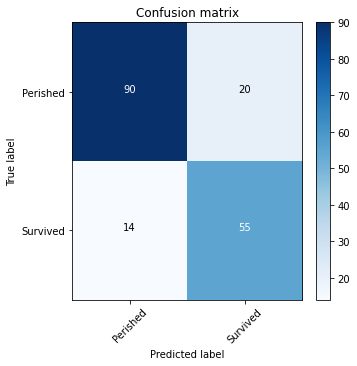

In [0]:
with mlflow.start_run(run_name="PassiveAgressive") as run:
    clf_pac = PassiveAggressiveClassifier(C=0.1, 
                                          fit_intercept=True, 
                                          max_iter=100, 
                                          shuffle=True, 
                                          verbose=0, 
                                          loss='hinge', 
                                          n_jobs=-1, 
                                          random_state=0, 
                                          warm_start=False, 
                                          class_weight=None).fit(X_train, y_train)

    cv_pac = mean_scores_cv(clf_pac, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_pac}\n")

    roc_pac = clf_eval(clf_pac, X_test, y_test)
    mlflow.log_metric("roc", roc_pac)

### 5.1.5 - [SGDC Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)  

The SGDC classifier is a linear classifier (SVM, logistic regression) with SGD training. Implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.  

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.

In [0]:
from sklearn.linear_model import SGDClassifier

Using f1 score
This is the cross validated score of the model: 0.7247224885542963

Classification Report
              precision    recall  f1-score   support

    Perished       0.79      0.77      0.78       110
    Survived       0.65      0.67      0.66        69

    accuracy                           0.73       179
   macro avg       0.72      0.72      0.72       179
weighted avg       0.73      0.73      0.73       179

ROC Score: 0.7196969696969695
Accuracy Score: 0.7318435754189944
Average Precision Score: 0.5604165027408399
f1 Score: 0.6571428571428573
Confusion matrix, without normalization
[[85 25]
 [23 46]]


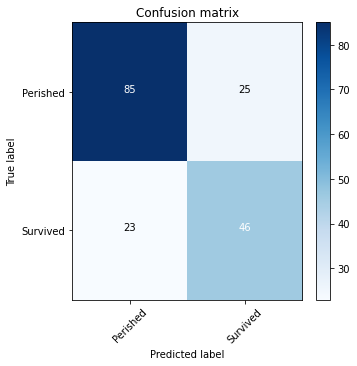

In [0]:
with mlflow.start_run(run_name="SGDC") as run:
    clf_sgdc = SGDClassifier(loss='hinge',
                             penalty='l2', 
                             alpha=0.0001,
                             l1_ratio=0.15, 
                             fit_intercept=True,
                             max_iter=200, 
                             shuffle=True,
                             verbose=0,
                             epsilon=0.01,
                             n_jobs=-1,
                             random_state=0,
                             learning_rate='optimal',
                             eta0=0.0, 
                             power_t=0.5,
                             class_weight=None,
                             warm_start=False, 
                             average=False).fit(X_train, y_train)

    cv_sgdc = mean_scores_cv(clf_sgdc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_sgdc}\n")

    roc_sgdc = clf_eval(clf_sgdc, X_test, y_test)
    mlflow.log_metric("roc", roc_sgdc)

### 5.1.6 - [Support Vector Machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/  

Support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

An SVM will find a hyperplane or a boundary between the two classes of data that maximizes. There are other planes as well which can separate the two classes, but only the SVM hyperplane can maximize the margin between the classes.

B0 + (B1 * X1) + (B2 * X2) = 0 where, B1 and B2 determines the slope of the line and B0 (intercept) found by the learning algorithm. X1 and X2 are the two input variables.

![SVM](https://www.researchgate.net/publication/331308937/figure/fig1/AS:870140602249216@1584469094771/Illustration-of-support-vector-machine-SVM-to-generalize-the-optimal-separating.ppm)

#### Choosing the best parameters using [GridSearchCV](http://scikit-learn.org/stable/modules/grid_search.html) or [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [0]:
from sklearn import svm

2022/12/11 13:49:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
0.8142241379310345
rbf
1.0
2
scale
Using f1 score
This is the cross validated score of the model: 0.779798127524338

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.87      0.86       110
    Survived       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8204216073781291
Accuracy Score: 0.8324022346368715
Average Precision Score: 0.6969995782563984
f1 Score: 0.7794117647058824
Confusion matrix, without normalization
[[96 14]
 [16 53]]


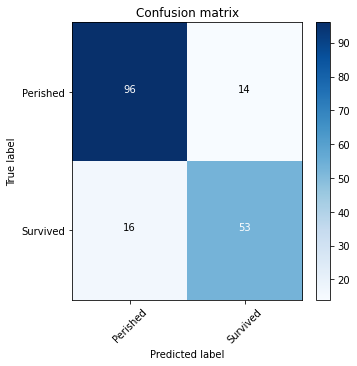

In [0]:
with mlflow.start_run(run_name="SVC-GS") as run:
    estimator = svm.SVC()

    #kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    kernels = ['poly', 'rbf']
    Cs = np.linspace(0.1,3,5)
    degrees = [2,3]
    gammas = np.logspace(-5, 0, 5)

    #param_grid=dict(kernel=kernels, C=Cs, gamma=gammas, degree=degrees)
    param_grid=dict(kernel=kernels, degree=degrees)


    clf_svc = model_selection.GridSearchCV(param_grid=param_grid,                       ## Grid Search (more exhaustive)
    #clf_svc = model_selection.RandomizedSearchCV(param_distributions=param_grid,       ## Randomized (faster)
                                                  estimator=estimator,
                                                  cv=cv,                                       ## using cross validation
                                                  #n_jobs=-1
                                                  )

    #clf_svc.fit(X_train, y_train)
    with parallel_backend('spark', n_jobs=100):     #If we have a spark backend available https://github.com/joblib/joblib-spark
        clf_svc.fit(X_train, y_train)

    print(clf_svc.best_score_)
    print(clf_svc.best_estimator_.kernel)
    print(clf_svc.best_estimator_.C)
    print(clf_svc.best_estimator_.degree)
    print(clf_svc.best_estimator_.gamma)
    cv_svc = mean_scores_cv(clf_svc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_svc}\n")

    roc_svc = clf_eval(clf_svc, X_test, y_test)
    mlflow.log_metric("roc", roc_svc)

## 5.2 - [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)  

k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression:

+ In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

+ In k-NN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.

k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The k-NN algorithm is among the simplest of all machine learning algorithms.

It works by finding the distances between the new data point added and the points already existed in the two separate classes. Whatever class got the highest votes, the new data point belongs to that class.

EuclideanDistance(x, xi) = sqrt( sum( (xj — xij)² ) )

![knn](https://miro.medium.com/max/1400/1*T8Pnw0kiVbrPGnqnB2I_Zw.jpeg)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

Using f1 score
This is the cross validated score of the model: 0.7605734638501724

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.81      0.84       110
    Survived       0.73      0.81      0.77        69

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.82      0.81      0.81       179

ROC Score: 0.8103425559947299
Accuracy Score: 0.8100558659217877
Average Precision Score: 0.6628760277047866
f1 Score: 0.767123287671233
Confusion matrix, without normalization
[[89 21]
 [13 56]]


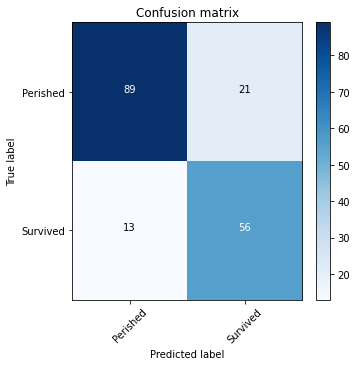

In [0]:
with mlflow.start_run(run_name="KNN") as run:
    clf_knn = KNeighborsClassifier(n_neighbors=25,
                                   weights='uniform', 
                                   algorithm='auto', 
                                   leaf_size=30, 
                                   p=4, 
                                   metric='minkowski', 
                                   metric_params=None, 
                                   n_jobs=-1).fit(X_train, y_train)

    cv_knn = mean_scores_cv(clf_knn, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_knn}\n")

    roc_knn = clf_eval(clf_knn, X_test, y_test)
    mlflow.log_metric("roc", roc_knn)

## 5.3 - [Decision Trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  

Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Decision tree algorithms are referred to as CART or Classification and Regression Trees. It is a flowchart like a tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

+ A Gini score gives an idea of how good a split is by how mixed the response classes are in the groups created by the split.

![dtree](https://elf11.github.io/images/decisionTree.png)

In [0]:
from sklearn.tree import DecisionTreeClassifier

Using f1 score
This is the cross validated score of the model: 0.7417158463743918

Classification Report
              precision    recall  f1-score   support

    Perished       0.83      0.84      0.83       110
    Survived       0.74      0.72      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

ROC Score: 0.7805006587615284
Accuracy Score: 0.7932960893854749
Average Precision Score: 0.6389670757785748
f1 Score: 0.7299270072992701
Confusion matrix, without normalization
[[92 18]
 [19 50]]


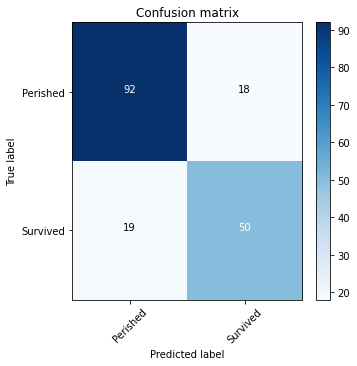

In [0]:
with mlflow.start_run(run_name="DecisionTree") as run:
    clf_dtc = DecisionTreeClassifier(criterion='gini', 
                                     splitter='best', 
                                     max_depth=None, 
                                     min_samples_split=3, 
                                     min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, 
                                     max_features=None, 
                                     random_state=0, 
                                     max_leaf_nodes=None, 
                                     class_weight=None,).fit(X_train, y_train)

    cv_dtc = mean_scores_cv(clf_dtc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_dtc}\n")

    roc_dtc = clf_eval(clf_dtc, X_test, y_test)
    mlflow.log_metric("roc", roc_dtc)

## 5.4 - [Ensemble Classifiers](http://scikit-learn.org/stable/modules/ensemble.html)

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

We have many type of ensembles: 
+ Bagging
+ Boosting 
+ Voting & Stacking

### 5.4.1 - Bagging

Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Random Forests are the most common type of bagging algorithms.

#### 5.4.1.1 -  [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

http://blog.yhathq.com/posts/random-forests-in-python.html  
http://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/  

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

+ Random forests involve creating multiple decision trees using bootstrapped datasets of the original data and randomly selecting a subset of variables at each step of the decision tree.     
+ The model then selects the mode of all of the predictions of each decision tree (bagging).

In [0]:
from sklearn.ensemble import RandomForestClassifier

Using f1 score
This is the cross validated score of the model: 0.7836013960089151

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.90      0.88       110
    Survived       0.83      0.78      0.81        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

ROC Score: 0.841304347826087
Accuracy Score: 0.8547486033519553
Average Precision Score: 0.7339661067618318
f1 Score: 0.8059701492537313
Confusion matrix, without normalization
[[99 11]
 [15 54]]


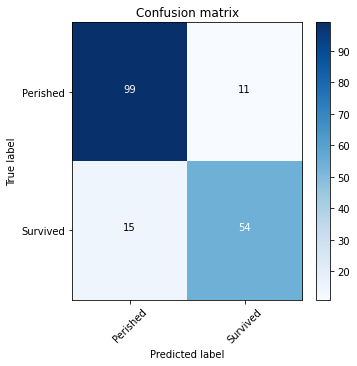

In [0]:
with mlflow.start_run(run_name="RandomForest") as run:
    clf_rf = RandomForestClassifier(n_estimators=300, 
                                    criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=3, #2,
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, 
                                    max_features='sqrt', 
                                    max_leaf_nodes=None, 
                                    bootstrap=True, 
                                    oob_score=False, 
                                    n_jobs=-1, 
                                    random_state=0, 
                                    verbose=0, 
                                    warm_start=False, 
                                    class_weight=None).fit(X_train, y_train)

    cv_rf = mean_scores_cv(clf_rf, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_rf}\n")

    roc_rf = clf_eval(clf_rf, X_test, y_test)
    mlflow.log_metric("roc", roc_rf)

#### 5.4.1.2 -  [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)   

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [0]:
from sklearn.ensemble import BaggingClassifier

Using f1 score
This is the cross validated score of the model: 0.7716115333355746

Classification Report
              precision    recall  f1-score   support

    Perished       0.88      0.83      0.85       110
    Survived       0.75      0.81      0.78        69

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.82      0.82       179

ROC Score: 0.819433465085639
Accuracy Score: 0.8212290502793296
Average Precision Score: 0.6786160364882736
f1 Score: 0.7777777777777779
Confusion matrix, without normalization
[[91 19]
 [13 56]]


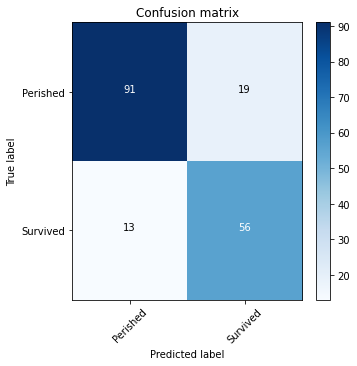

In [0]:
with mlflow.start_run(run_name="Bagging") as run:
    clf_bgc = BaggingClassifier(clf_lr).fit(X_train, y_train)   ## Using the previously fitted Logistic Regression

    cv_bgc = mean_scores_cv(clf_bgc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_bgc}\n")

    roc_bgc = clf_eval(clf_bgc, X_test, y_test)
    mlflow.log_metric("roc", roc_bgc)

#### 5.4.1.3 - [Extra Trees Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

Using f1 score
This is the cross validated score of the model: 0.7864265634191423

Classification Report
              precision    recall  f1-score   support

    Perished       0.87      0.86      0.87       110
    Survived       0.79      0.80      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Score: 0.830368906455863
Accuracy Score: 0.8379888268156425
Average Precision Score: 0.7045062863620065
f1 Score: 0.7913669064748201
Confusion matrix, without normalization
[[95 15]
 [14 55]]


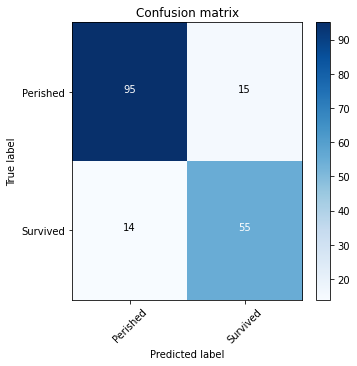

In [0]:
with mlflow.start_run(run_name="ExtraTree") as run:
    clf_etc = ExtraTreesClassifier(n_estimators=300,
                                   max_depth=None,
                                   min_samples_split=3,
                                   random_state=0).fit(X_train, y_train)

    cv_etc = mean_scores_cv(clf_etc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_etc}\n")

    roc_etc = clf_eval(clf_etc, X_test, y_test)
    mlflow.log_metric("roc", roc_etc)

### 5.4.2 - Boosting

Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. Boosting is based on the question posed by Kearns and Valiant (1988, 1989): Can a set of weak learners create a single strong learner? A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

#### 5.4.2.1 - [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Adaptive boost is also an ensemble algorithm that leverages bagging and boosting methods to develop an enhanced predictor.

+ AdaBoost creates a forest of stumps rather than trees. A stump is a tree that is made of only one node and two leaves.
+ AdaBoost takes a more iterative approach in the sense that it seeks to iteratively improve from the mistakes that the previous stump(s) made.

In [0]:
from sklearn.ensemble import AdaBoostClassifier

Using f1 score
This is the cross validated score of the model: 0.7831145041927723

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.82      0.84       110
    Survived       0.73      0.78      0.76        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.81       179

ROC Score: 0.800395256916996
Accuracy Score: 0.8044692737430168
Average Precision Score: 0.6548917146439615
f1 Score: 0.7552447552447553
Confusion matrix, without normalization
[[90 20]
 [15 54]]


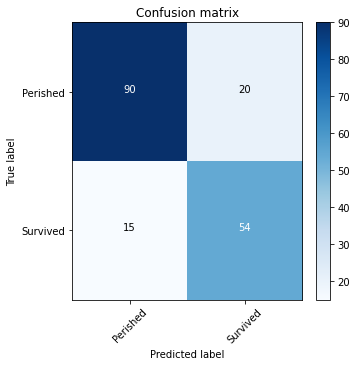

In [0]:
with mlflow.start_run(run_name="AdaBoost") as run:
    clf_abc = AdaBoostClassifier(base_estimator=None,
                                 n_estimators=300,
                                 learning_rate=0.1,
                                 algorithm='SAMME.R',
                                 random_state=0).fit(X_train, y_train)

    cv_abc = mean_scores_cv(clf_abc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_abc}\n")

    roc_abc = clf_eval(clf_abc, X_test, y_test)
    mlflow.log_metric("roc", roc_abc)

#### 5.4.2.2 - [Gradient Boost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html):  

Gradient Boost is also an ensemble algorithm that uses boosting methods to develop an enhanced predictor.

+ Unlike AdaBoost which builds stumps, Gradient Boost builds trees with usually 8–32 leaves.
+ Gradient Boost views the boosting problem as an optimization problem, where it uses a loss function and tries to minimize the error. This is why it’s called Gradient boost, as it’s inspired by gradient descent.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

Using f1 score
This is the cross validated score of the model: 0.7960200065398129

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.86      0.86       110
    Survived       0.78      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8231225296442688
Accuracy Score: 0.8324022346368715
Average Precision Score: 0.6962752531919613
f1 Score: 0.782608695652174
Confusion matrix, without normalization
[[95 15]
 [15 54]]


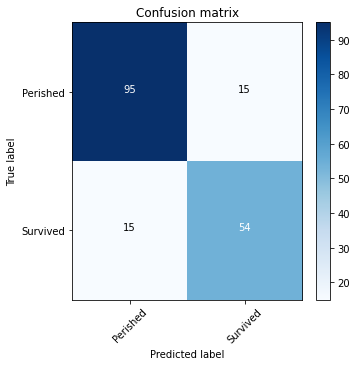

In [0]:
with mlflow.start_run(run_name="GradBoost") as run:
    clf_gbc = GradientBoostingClassifier(learning_rate=0.1,
                                         n_estimators=100,
                                         subsample=1.0,
                                         criterion='friedman_mse',
                                         min_samples_split=3, 
                                         min_samples_leaf=1, 
                                         min_weight_fraction_leaf=0.0, 
                                         max_depth=3, 
                                         init=None, 
                                         random_state=0, 
                                         max_features=None, 
                                         verbose=0, 
                                         max_leaf_nodes=None, 
                                         warm_start=False,
                                         validation_fraction=0.1, 
                                         n_iter_no_change=None, 
                                         tol=0.0001, 
                                         ccp_alpha=0.0).fit(X_train, y_train)
                                     
    cv_gbc = mean_scores_cv(clf_gbc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_gbc}\n")                                   
                                     
    roc_gbc = clf_eval(clf_gbc, X_test, y_test)   
    mlflow.log_metric("roc", roc_gbc)

#### 5.4.2.3 - [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package)  

XGBoost is one of the most popular and widely used algorithms today because it is simply so powerful.

+ It is similar to Gradient Boost but has a few extra features that make it that much stronger.
+ Newton Boosting — Provides a direct route to the minima than gradient descent, making it much faster.
+ An extra randomization parameter — reduces the correlation between trees, ultimately improving the strength of the ensemble.

In [0]:
import xgboost

Using f1 score
This is the cross validated score of the model: 0.7833546922742267

Classification Report
              precision    recall  f1-score   support

    Perished       0.85      0.93      0.89       110
    Survived       0.86      0.74      0.80        69

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179

ROC Score: 0.833201581027668
Accuracy Score: 0.8547486033519553
Average Precision Score: 0.7394680180977592
f1 Score: 0.796875
Confusion matrix, without normalization
[[102   8]
 [ 18  51]]


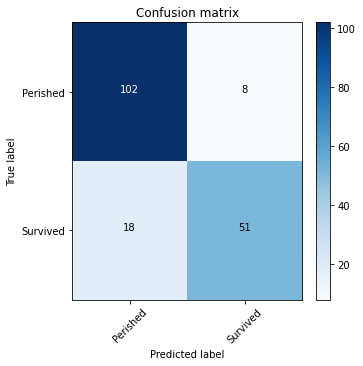

In [0]:
with mlflow.start_run(run_name="XGBoost") as run:
    clf_xgb = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                            learning_rate=0.1,
                                            n_estimators=250,
                                            max_delta_step=0,
                                            max_depth=2,
                                            min_child_weight=1,
                                            missing=1,
                                            gamma=0.1,
                                            subsample=1,
                                            colsample_bylevel=1,
                                            colsample_bytree=1,
                                            objective= 'binary:logitraw',
                                            #objective='multi:softprob',
                                            eval_metric='auc',
                                            #eval_metric='logloss',
                                            reg_alpha=0, 
                                            reg_lambda=1,
                                            nthread=-1,
                                            scale_pos_weight=1,
                                            seed=0,
                                            use_label_encoder=False,
                                            random_state=0).fit(X_train, y_train)

    cv_xgb = mean_scores_cv(clf_xgb, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_xgb}\n")

    roc_xgb = clf_eval(clf_xgb, X_test, y_test)
    mlflow.log_metric("roc", roc_xgb)

#### 5.4.2.4 - Light GBM: 

It is another type of boosting algorithm that has shown to be faster and sometimes more accurate than XGBoost.

+ It uses a unique technique called Gradient-based One-side sampling (GOSS) to filter out the data instances to find a split value.

In [0]:
import lightgbm as lgb

Using f1 score
This is the cross validated score of the model: 0.7986393409667984

Classification Report
              precision    recall  f1-score   support

    Perished       0.88      0.85      0.87       110
    Survived       0.78      0.81      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Score: 0.8330698287220025
Accuracy Score: 0.8379888268156425
Average Precision Score: 0.703865633911784
f1 Score: 0.7943262411347518
Confusion matrix, without normalization
[[94 16]
 [13 56]]


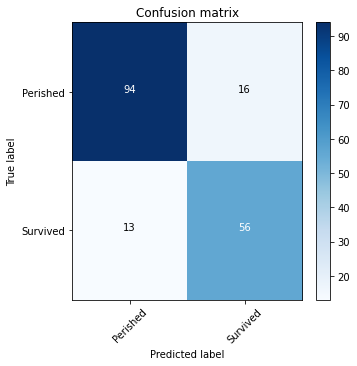

In [0]:
with mlflow.start_run(run_name="LightGBM") as run:
    params = {'boosting_type': 'gbdt',
              'max_depth' : -1,
              'objective': 'binary',
              'num_leaves': 64, 
              'learning_rate': 0.05, 
              'max_bin': 512, 
              'subsample_for_bin': 200,
              'subsample': 1, 
              'subsample_freq': 1, 
              'colsample_bytree': 0.8, 
              'reg_alpha': 5, 
              'reg_lambda': 10,
              'min_split_gain': 0.15, 
              'min_child_weight': 1, 
              'min_child_samples': 5, 
              'scale_pos_weight': 1,
              'num_class' : 1,
              'metric' : 'binary_error'}

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    clf_lgb = lgb.LGBMClassifier(boosting_type= 'gbdt',
                                 objective = 'binary',
                                 n_jobs = -1,
                                 max_depth = params['max_depth'],
                                 max_bin = params['max_bin'],
                                 subsample_for_bin = params['subsample_for_bin'],
                                 subsample = params['subsample'],
                                 subsample_freq = params['subsample_freq'],
                                 min_split_gain = params['min_split_gain'], 
                                 min_child_weight = params['min_child_weight'], 
                                 min_child_samples = params['min_child_samples'], 
                                 scale_pos_weight = params['scale_pos_weight'])

    clf_lgb.fit(X_train, y_train)
    cv_lgb = mean_scores_cv(clf_lgb, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_lgb}\n")

    roc_lgb = clf_eval(clf_lgb, X_test, y_test)
    mlflow.log_metric("roc", roc_lgb)

#### 5.4.2.5 - [Catboost](https://catboost.ai/)  

TBD - There is still a problem running inside Databricks environment

In [0]:
from catboost import CatBoostClassifier

Using f1 score
0:	learn: 0.5201013	total: 423us	remaining: 423us
1:	learn: 0.4731372	total: 673us	remaining: 0us
0:	learn: 0.5180396	total: 364us	remaining: 364us
1:	learn: 0.4748788	total: 622us	remaining: 0us
0:	learn: 0.5197820	total: 334us	remaining: 334us
1:	learn: 0.4859956	total: 647us	remaining: 0us
0:	learn: 0.5216518	total: 330us	remaining: 330us
1:	learn: 0.4746759	total: 633us	remaining: 0us
0:	learn: 0.5236030	total: 291us	remaining: 291us
1:	learn: 0.4906221	total: 609us	remaining: 0us
0:	learn: 0.5211026	total: 329us	remaining: 329us
1:	learn: 0.4748427	total: 639us	remaining: 0us
0:	learn: 0.5156343	total: 300us	remaining: 300us
1:	learn: 0.4711532	total: 558us	remaining: 0us
0:	learn: 0.5237640	total: 283us	remaining: 283us
1:	learn: 0.4777257	total: 534us	remaining: 0us
0:	learn: 0.5246804	total: 336us	remaining: 336us
1:	learn: 0.4890649	total: 817us	remaining: 0us
0:	learn: 0.5133967	total: 285us	remaining: 285us
1:	learn: 0.4571350	total: 576us	remaining: 0us
This 

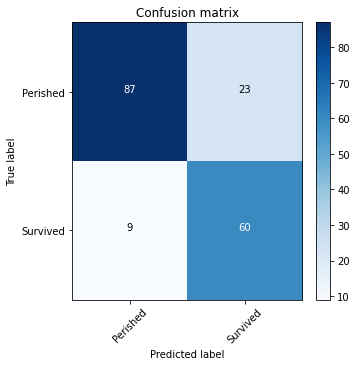

In [0]:
tmp_path = '/tmp'

with mlflow.start_run(run_name="CatBoost") as run:
    clf_ctb = CatBoostClassifier(iterations=2,
                                 learning_rate=1,
                                 depth=2,
                                 train_dir=tmp_path)
    clf_ctb.fit(X_train, y_train, verbose=False)

    cv_ctb = mean_scores_cv(clf_ctb, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_ctb}\n")

    roc_ctb = clf_eval(clf_ctb, X_test, y_test)
    mlflow.log_metric("roc", roc_ctb)

#### 5.4.2.6 - [Regularized Greedy Forest](https://github.com/RGF-team/rgf)

https://www.analyticsvidhya.com/blog/2018/02/introductory-guide-regularized-greedy-forests-rgf-python/  

In Boosting algorithms, each classifier/regressor is trained on data, taking into account the previous classifiers’/regressors’ success. After each training step, the weights are redistributed. Mis-classified data increases its weights to emphasize the most difficult cases. In this way, subsequent learners will focus on them during their training. However, the boosting methods simply treat the decision tree base learner as a black box and it does not take advantage of the tree structure itself.  In a sense, boosting does a partial corrective step to the model at each iteration. In contrast, RGF performs 2 steps:

+ Finds the one step structural change to the current forest to obtain the new forest that minimises the loss function (e.g. Least squares or logloss)
+ Adjusts the leaf weights for the entire forest to minimize the loss function

In [0]:
from rgf.sklearn import RGFClassifier, FastRGFClassifier

Using f1 score
This is the cross validated score of the model: 0.7928226529350969

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.83      0.84       110
    Survived       0.74      0.78      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

ROC Score: 0.8049407114624505
Accuracy Score: 0.8100558659217877
Average Precision Score: 0.6627149041228984
f1 Score: 0.7605633802816901
Confusion matrix, without normalization
[[91 19]
 [15 54]]


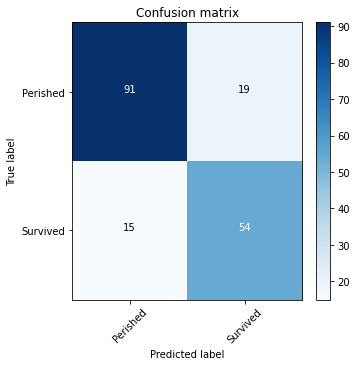

In [0]:
with mlflow.start_run(run_name="RegGreedyForest") as run:
    clf_rgf = RGFClassifier(max_leaf=100,
                            algorithm="RGF_Sib",
                            test_interval=60,
                            verbose=False,).fit(X_train, y_train)

    cv_rgf = mean_scores_cv(clf_rgf, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_rgf}\n")

    roc_rgf = clf_eval(clf_rgf, X_test, y_test)
    mlflow.log_metric("roc", roc_rgf)

## 5.5 - [Bayesian Classifiers](http://scikit-learn.org/stable/modules/naive_bayes.html)  

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html  
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html  

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

+ As the name specifies, this algorithm is entirely based on Bayes's theorem. Bayes’ theorem says we can calculate the probability of a piece of data belonging to a given class if prior knowledge is given.  
+ P(class|data) = (P(data|class) * P(class)) / P(data)

In [0]:
from sklearn.naive_bayes import BernoulliNB

Using f1 score
This is the cross validated score of the model: 0.7428824777451629

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.81      0.83       110
    Survived       0.72      0.78      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.80      0.80       179

ROC Score: 0.7958498023715415
Accuracy Score: 0.7988826815642458
Average Precision Score: 0.6472771435511294
f1 Score: 0.7499999999999999
Confusion matrix, without normalization
[[89 21]
 [15 54]]


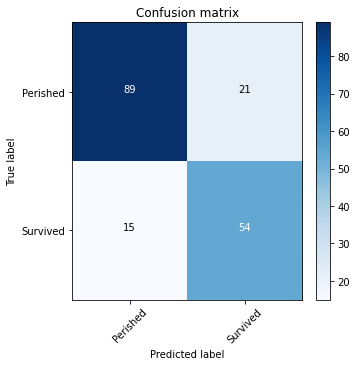

In [0]:
with mlflow.start_run(run_name="BernoulliNB") as run:
    clf_bnb = BernoulliNB(alpha=0.20, 
                          binarize=0.0, 
                          fit_prior=True, 
                          class_prior=None).fit(X_train, y_train)

    cv_bnb = mean_scores_cv(clf_bnb, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_bnb}\n")

    roc_bnb = clf_eval(clf_bnb, X_test, y_test)
    mlflow.log_metric("roc", roc_bnb)

## 5.6 - Gaussian Processes

In the simple linear regression setting, we have a dependent variable y that we assume can be modeled as a function of an independent variable x, i.e. y=f(x)+ϵ (where ϵ is the irreducible error) but we assume further that the function f defines a linear relationship and so we are trying to find the parameters $θ_0$ and $θ_1$ which define the intercept and slope of the line respectively, i.e. $y=θ_0+θ_1x+ϵ$.
+ Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. 
+ The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions $f(x)$ that are consistent with the observed data. As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

In [0]:
from sklearn.gaussian_process import GaussianProcessClassifier

Using f1 score
This is the cross validated score of the model: 0.7820732699928655

Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.85      0.86       110
    Survived       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Score: 0.8185770750988142
Accuracy Score: 0.8268156424581006
Average Precision Score: 0.6875255907560984
f1 Score: 0.7769784172661871
Confusion matrix, without normalization
[[94 16]
 [15 54]]


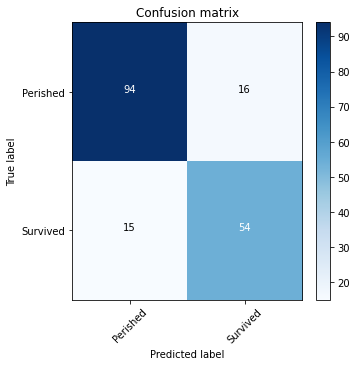

In [0]:
with mlflow.start_run(run_name="GausianProcesses") as run:
    clf_gpc = GaussianProcessClassifier(kernel=None, 
                                        optimizer='fmin_l_bfgs_b', 
                                        n_restarts_optimizer=0, 
                                        max_iter_predict=100, 
                                        warm_start=False, 
                                        copy_X_train=True, 
                                        random_state=0, 
                                        multi_class='one_vs_rest', 
                                        n_jobs=-1).fit(X_train, y_train)

    cv_gpc = mean_scores_cv(clf_gpc, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_gpc}\n")

    roc_gpc = clf_eval(clf_gpc, X_test, y_test)
    mlflow.log_metric("roc", roc_gpc)

## 5.7 - Neural Networks

Neural Networks take inspiration from the learning process occurring in human brains. They consists of an artificial network of functions, called parameters, which allows the computer to learn, and to fine tune itself, by analyzing new data. Each "neuron" learns the parameters of a function which produces an output, after receiving one or multiple inputs. Those outputs are then passed to the next layer of neurons, which use them as inputs of their own function, and produce further outputs. Those outputs are then passed on to the next layer of neurons, and so it continues until every layer of neurons have been considered, and the terminal neurons have received their input. Those terminal neurons then output the final result for the model.

In [0]:
import tensorflow as tf
import datetime

Monitoring with [Tensorboard](https://www.tensorflow.org/tensorboard/) on [Databricks](https://docs.databricks.com/machine-learning/train-model/tensorflow.html#using-tensorboard)

In [0]:
%load_ext tensorboard
experiment_log_dir = logpath + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                400       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 40)                840       
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_14 (Dense)            (None, 20)                820       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

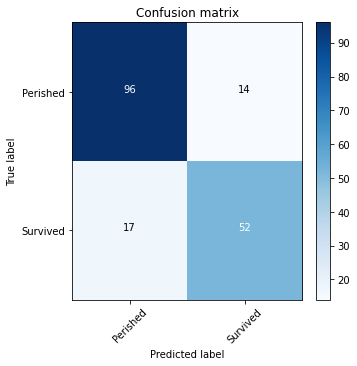

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

batch_size = int(len(X_train)/25)
num_classes = 2
epochs = 30
np.random.seed(0)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(input_dim=X_train.shape[1], units=20, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=40, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=20, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

with mlflow.start_run(run_name="KerasNN") as run:

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[early_callback, tensorboard_callback],
                        verbose=0,
                        shuffle=False,
                        validation_split=0.2,
                        #validation_data=(X_test, y_test)
                       )

    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    y_pred = (model.predict(X_test) > 0.5).astype("int32")


    clf_matrix = confusion_matrix(y_test, y_pred)
    print('Classification Report')
    print(classification_report(y_test, y_pred, target_names=['Perished', 'Survived']))
    print('ROC Score: {}'.format(roc_auc_score(y_test, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_test, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_test, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=['Perished', 'Survived'])
    roc_keras = roc_auc_score(y_test, y_pred)
    mlflow.log_metric("roc", roc_keras)

In [0]:
%tensorboard --logdir $experiment_log_dir

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under `/dbfs/` to persist your logs in DBFS.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

In [0]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


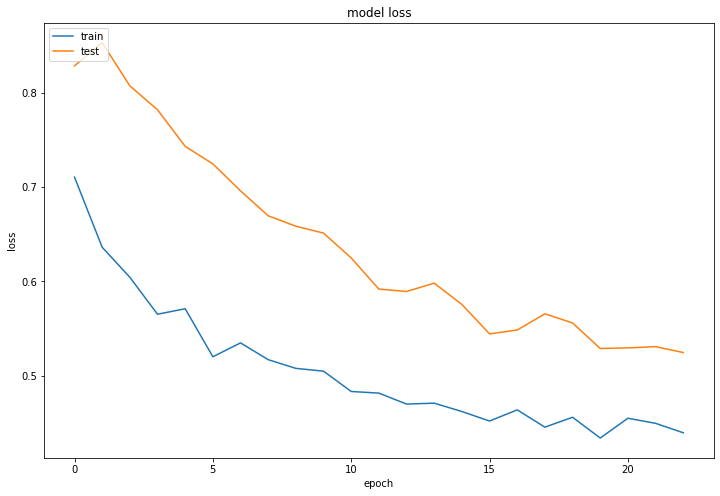

In [0]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

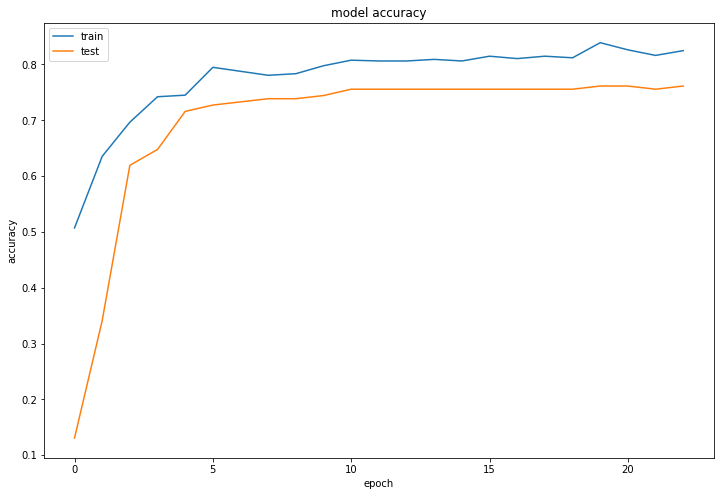

In [0]:
# summarize history for accuracy
plt.figure(figsize=(12,8))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5.8 - AutoML / Genetic Algorithms

### 5.8.1 - [TPOT](https://github.com/rhiever/tpot)  

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

In [0]:
from tpot import TPOTClassifier


2.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: ExtraTreesClassifier(RFE(StandardScaler(input_matrix), criterion=gini, max_features=0.3, n_estimators=100, step=0.6000000000000001), bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=9, n_estimators=100)
Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.87      0.87       110
    Survived       0.79      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Score: 0.8276679841897234
Accuracy Score: 0.8379888268156425
Average Precision Score: 0.7052822586406435
f1 Score: 0.7883211678832117
Confusion matrix, without normalization
[[96 14]
 [15 54]]


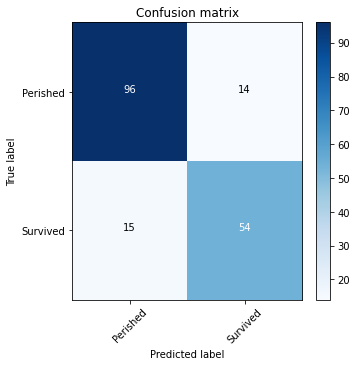

2022/12/11 13:54:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2022/12/11 13:54:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/12/11 13:54:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [0]:
mlflow.autolog(disable=True)

with mlflow.start_run(run_name="TPOT") as run:
    clf_tpot = TPOTClassifier(verbosity=1, 
                              max_time_mins=2, 
                              max_eval_time_mins=1, 
                              population_size=10,
                              generations=100,
                              n_jobs=-1)

    clf_tpot.fit(X_train, y_train)

    #cv_tpot = mean_scores_cv(clf_tpot, cv, X_train, y_train)
    #print(f"This is the cross validated score of the model: {cv_tpot}\n")

    roc_tpot = clf_eval(clf_tpot, X_test, y_test)
    mlflow.log_metric("roc", roc_tpot)

mlflow.autolog(disable=False)

### 5.4.3 - [Voting / Stacking](http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier)  

https://medium.com/@satyam-kumar/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e

Voting algorithms are simple strategies, where you aglomerate results of classifiers' decisions by for example taking the class which appears in most cases. 

Stacking/grading strategies are generalizations of this concept. Instead of simply saying "ok, I have a scheme v, which I will use to select the best answer among my k classifiers" you create another abstraction layer, where you actually learn to predict the correct label having k votes.

In [0]:
from sklearn.ensemble import VotingClassifier

2022/12/11 13:54:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '339e98634d654ccd81dec014aea0d636', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/12/11 13:54:12 WARNING mlflow.utils: Truncated the value of the key `estimators`. Truncated value: `[('clf_sgdc', SGDClassifier(epsilon=0.01, max_iter=200, n_jobs=-1, random_state=0)), ('clf_lgr', LogisticRegression(C=0.1, multi_class='ovr', n_jobs=-1, random_state=0,
                   solver='saga', tol=0.001)), ('clf_rdg', RGFClassifier(algor...`
2022/12/11 13:54:12 WARNING mlflow.utils: Truncated the value of the key `clf_xgb`. Truncated value: `XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type=None,
              interac...`
2022/12/11 13:54:15 WARNING 

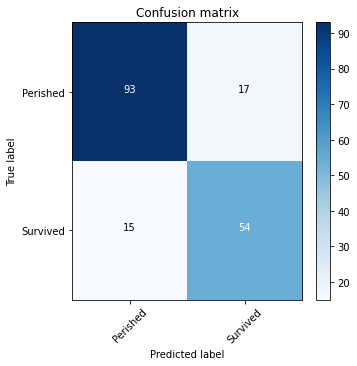

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    with mlflow.start_run(run_name="Voting") as run:
        ensemble = VotingClassifier(estimators=[('clf_sgdc', clf_sgdc),
                                                ('clf_lgr', clf_lr),
                                                ('clf_rdg', clf_rgf),
                                                ('clf_bgc', clf_bgc),
                                                ('clf_etc', clf_etc),
                                                ('clf_abc', clf_abc),
                                                ('clf_pct', clf_pcp),
                                                ('clf_xgb', clf_xgb),
                                                ('clf_rf', clf_rf),
                                                ('clf_knn', clf_knn),
                                                ('clf_rgf', clf_rgf),
                                                ('clf_ctb', clf_ctb),
                                                #('clf_tpot', clf_tpot),
                                               ],
                                    voting='hard',
                                    weights=[1,1,1,1,1,1,1,1,1,1,1,1]).fit(X_train, y_train)

    cv_ens = mean_scores_cv(ensemble, cv, X_train, y_train)
    print(f"This is the cross validated score of the model: {cv_ens}\n")
    
    roc_ens = clf_eval(ensemble, X_test, y_test)
    mlflow.log_metric("roc", roc_ens)

# 6 - Evaluating the results:

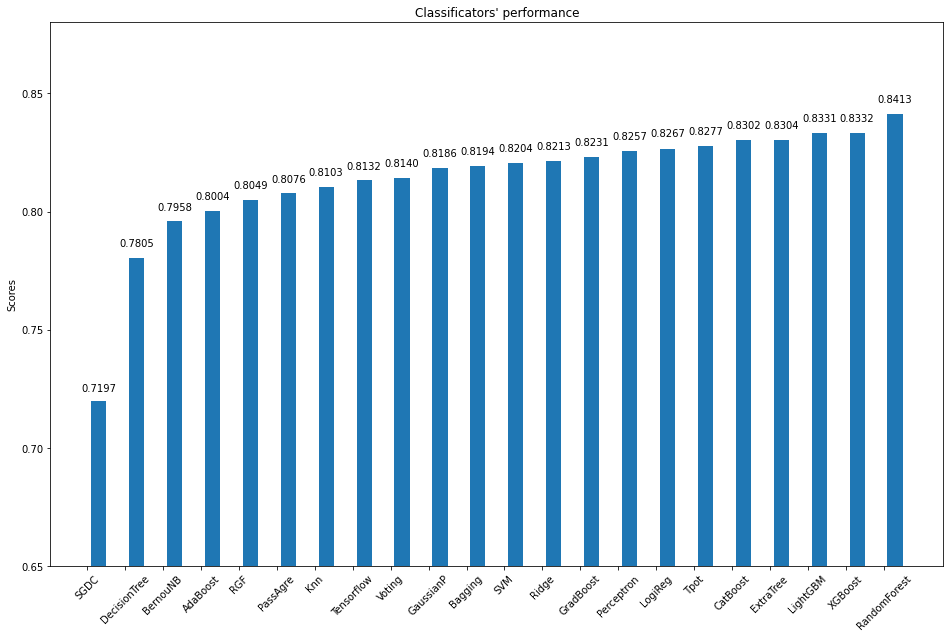

In [0]:
dic_results = {'SVM': roc_svc,
               'RandomForest': roc_rf,
               'DecisionTree': roc_dtc,
               'ExtraTree': roc_etc,
               'AdaBoost': roc_abc,
               'GradBoost': roc_gbc,
               'LightGBM': roc_lgb,
               'SGDC': roc_sgdc,
               'Ridge': roc_rdg,
               'Perceptron': roc_pcp,
               'PassAgre': roc_pac,
               'LogiReg': roc_lr,
               'BernouNB': roc_bnb,
               'RGF': roc_rgf,
               'XGBoost':roc_xgb,
               'Knn':roc_knn,
               'Tensorflow': roc_keras,
               'Bagging': roc_bgc,
               'Voting': roc_ens,
               'Tpot': roc_tpot,
               'CatBoost': roc_ctb,
               'RGF': roc_rgf,
               'GaussianP': roc_gpc,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.65,ymax = 0.88)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

In [0]:
features = X_train.columns
df_fi = pd.DataFrame({'clf_lr': (abs(clf_lr.coef_[0])/sum(abs(clf_lr.coef_[0]))),    #a sort of adaptation
                      'clf_rf':clf_rf.feature_importances_,
                      'clf_xgb':clf_xgb.feature_importances_,
                      'clf_etc':clf_etc.feature_importances_,
                      'clf_abc':clf_abc.feature_importances_,
                      #'clf_bgc':clf_bgc.estimators_[0].feature_importances_,
                      'clf_bgc':(abs(clf_lr.coef_[0])/sum(abs(clf_lr.coef_[0]))),   # Adapting to linear regression classifiers in our bagging strategy
                      'clf_gbc':clf_gbc.feature_importances_,
                      'clf_lgb':clf_lgb.feature_importances_ / sum(clf_lgb.feature_importances_),
                      'clf_ctb': clf_ctb.feature_importances_  / sum(clf_ctb.feature_importances_),
                     },
                      index=features)
df_fi['mean_importance'] = df_fi.mean(axis=1)
df_fi.sort_values(['mean_importance'], ascending=False, inplace=True)
df_fi

,clf_lr,clf_rf,clf_xgb,clf_etc,clf_abc,clf_bgc,clf_gbc,clf_lgb,clf_ctb,mean_importance
Mr,0.100432,0.125929,0.565309,0.141355,0.066667,0.100432,0.470079,0.018692,0.000000,0.176544
Age,0.093561,0.189826,0.017483,0.149319,0.216667,0.093561,0.126982,0.383178,0.000000,0.141175
Fare,0.027329,0.175932,0.015202,0.152609,0.180000,0.027329,0.107997,0.323097,0.000000,0.112166
male,0.080569,0.078882,0.000000,0.074697,0.036667,0.080569,0.004558,0.002670,0.627530,0.109571
SibSp,0.137710,0.053579,0.040903,0.055718,0.120000,0.137710,0.090117,0.042056,0.096096,0.085988
Pclass,0.128612,0.071887,0.081488,0.087585,0.080000,0.128612,0.075033,0.031375,0.000000,0.076066
Deck,0.034300,0.052968,0.028458,0.049383,0.086667,0.034300,0.041862,0.074766,0.130018,0.059192
Master,0.094169,0.011028,0.021277,0.020369,0.050000,0.094169,0.002401,0.003338,0.146356,0.049234
female,0.080569,0.069335,0.081065,0.086043,0.010000,0.080569,0.002273,0.016021,0.000000,0.047319
surname,0.021856,0.059165,0.027204,0.063154,0.060000,0.021856,0.035379,0.043391,0.000000,0.036889


## 6.1 - Optimizing the best Model

2022/12/11 14:08:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, 238 runs will be omitted.
0.8279519331243469
200
10
2
2
entropy
Classification Report
              precision    recall  f1-score   support

    Perished       0.86      0.90      0.88       110
    Survived       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

ROC Score: 0.8340579710144927
Accuracy Score: 0.8491620111731844
Average Precision Score: 0.7254814893530888
f1 Score: 0.7969924812030075
Confusion matrix, without normalization
[[99 11]
 [16 53]]


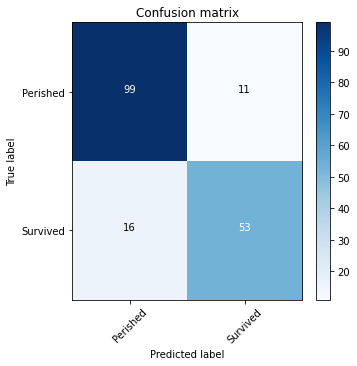

In [0]:
with mlflow.start_run(run_name="BestOptimal") as run:
    opt_model = RandomForestClassifier(min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=-1, 
                                       random_state=0, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None)


    n_estimators = [100, 150, 200]
    max_depth = [5, 10, None]
    min_samples_split = [1,2,3]
    min_samples_leaf = [2,3,4]
    criterion=['gini', 'entropy', 'log_loss']
    param_grid=dict(n_estimators=n_estimators, 
                    max_depth=max_depth, 
                    min_samples_split=min_samples_split, 
                    min_samples_leaf=min_samples_leaf,
                    criterion=criterion)



    clf_rfo = model_selection.GridSearchCV(param_grid=param_grid,                       ## Grid Search (more exhaustive)
    #clf_rfo = model_selection.RandomizedSearchCV(param_distributions=param_grid,       ## Randomized (faster)
                                           estimator=opt_model,
                                           cv=cv,                                       ## using cross validation
                                           n_jobs=-1)

    clf_rfo.fit(X_train, y_train)
    print(clf_rfo.best_score_)
    print(clf_rfo.best_estimator_.n_estimators)
    print(clf_rfo.best_estimator_.max_depth)
    print(clf_rfo.best_estimator_.min_samples_split)
    print(clf_rfo.best_estimator_.min_samples_leaf)
    print(clf_rfo.best_estimator_.criterion)
    roc_rfo = clf_eval(clf_rfo, X_test, y_test)
    mlflow.log_metric("roc", roc_rfo)